In [23]:
# imports:
from sklearnex import patch_sklearn
patch_sklearn()


import numpy as np
import pandas as pd
import os
import sklearn
import csv
import pickle
import time
import matplotlib.pyplot as plt

%matplotlib notebook

from tsfresh import extract_features
from tsfresh import extract_relevant_features
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold 
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold, StratifiedGroupKFold, cross_validate
from sklearn.model_selection import learning_curve
from sklearn.compose import make_column_transformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
DATAPATH = 'train'
DATASET = 'train_'

df = pd.DataFrame(dtype=float)
for i in range(1100):
    filename= os.path.join(DATAPATH, DATASET +str(i)+ '.csv')
    df_ = pd.read_csv(filename, index_col=0)
    df_['time'] = df_.index
    df_['index'] = i
    df = pd.concat([df, df_])

In [3]:
#extracted_features = extract_features(df, column_id="index", column_sort="time",n_jobs=0)
extracted_features =  pd.read_csv('raw_data.csv', index_col=0)

In [4]:
#extracted_features.to_csv('raw_data.csv', index=False)

In [5]:
data = extracted_features.dropna(axis=1)


In [6]:
data.head()

,0__has_duplicate_max,0__has_duplicate_min,0__has_duplicate,0__sum_values,0__abs_energy,0__mean_abs_change,0__mean_change,0__mean_second_derivative_central,0__median,0__mean,...,2__permutation_entropy__dimension_5__tau_1,2__permutation_entropy__dimension_6__tau_1,2__permutation_entropy__dimension_7__tau_1,"2__matrix_profile__feature_""min""__threshold_0.98","2__matrix_profile__feature_""max""__threshold_0.98","2__matrix_profile__feature_""mean""__threshold_0.98","2__matrix_profile__feature_""median""__threshold_0.98","2__matrix_profile__feature_""25""__threshold_0.98","2__matrix_profile__feature_""75""__threshold_0.98",2__mean_n_absolute_max__number_of_maxima_7
0__variance_larger_than_standard_deviation,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.0,1.0,-0.442275,0.851536,0.000479,0.000001,-2.294795e-07,0.000005,-0.000221,...,4.692189,6.233202,7.261476,0.984912,2.700453,1.828989,1.844765,1.693710,1.993897,0.000443
0.0,0.0,0.0,1.0,-0.766685,0.780623,0.000451,0.000010,-1.414164e-07,-0.000111,-0.000383,...,4.661746,6.222380,7.232477,0.807981,2.529134,1.781263,1.799463,1.594749,1.976426,0.000655
0.0,0.0,0.0,1.0,-0.523175,0.865784,0.000480,0.000006,-1.799299e-07,0.000007,-0.000262,...,4.684714,6.256297,7.296334,0.653066,2.346886,1.407556,1.416203,1.258539,1.564722,0.000430
0.0,0.0,0.0,1.0,-1.608302,0.820806,0.000448,0.000015,-9.759760e-08,-0.000793,-0.000804,...,4.677766,6.252514,7.300641,0.722925,2.715467,1.790795,1.802346,1.640931,1.976026,0.000596
0.0,0.0,0.0,1.0,-0.869434,0.782558,0.000446,0.000012,-1.245245e-07,-0.000066,-0.000435,...,4.655679,6.226455,7.271660,0.790224,2.489511,1.782093,1.798856,1.619191,1.962498,0.000634


<IPython.core.display.Javascript object>


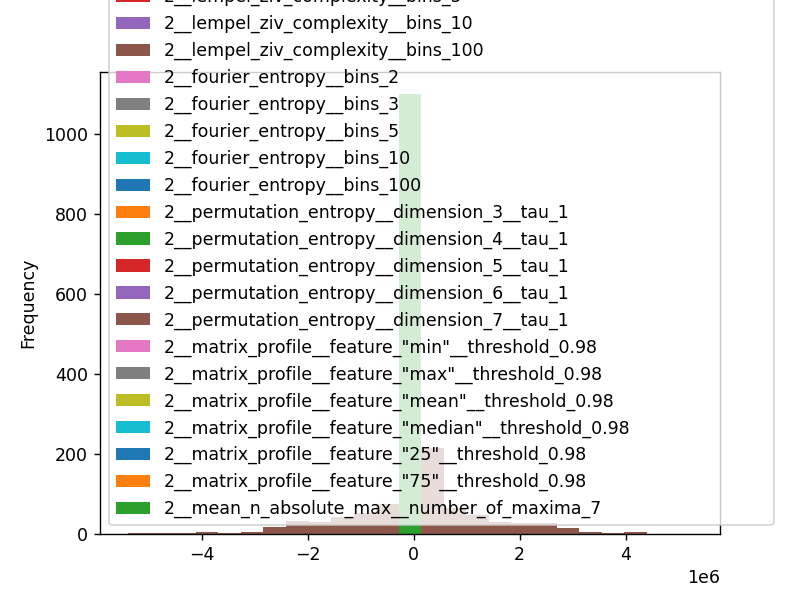

<AxesSubplot:ylabel='Frequency'>

In [7]:
data.plot.hist(bins=25)

In [8]:
df_meta = pd.read_csv("train_meta.csv")
y = df_meta["label"]
y = y.to_numpy()

In [9]:
n_folds =  15# Max 15 folds
cv = KFold(n_splits=n_folds, shuffle=True,random_state=1000)

In [48]:
preprocessing = Pipeline([
                        ('VT1', VarianceThreshold(threshold=0)),
                        ('QT', QuantileTransformer()),
                        ('VT2', VarianceThreshold(threshold=0))
                         ])  

#  Feature selection, you can also try others
feature_selection = Pipeline([('selectkbest', SelectKBest())])  

classifier = Pipeline([('clf', AdaBoostRegressor())])

pipe = Pipeline([
    
    ('feature_selection', feature_selection),
    ('classifier', classifier)])
#('preprocessing', preprocessing),

# You may need to specify other hyperparameters here if you investigate other blocks
k_grid = [100,160,200]
alpha_grid = [0.3]
learning_r = [1]
n_est = [200,300,400]
random_s = [1000]
l = ['linear']

# And make sure to add them to your param_grid

param_grid = {
    'feature_selection__selectkbest__k' : k_grid,
    'classifier__clf__n_estimators' : n_est,
    'classifier__clf__random_state' : random_s
}



# define GridSearchCV object

gridsearch = GridSearchCV(pipe, param_grid, n_jobs=4, verbose=3, 
                          return_train_score=True,scoring='neg_mean_absolute_error')

# Train the pipeline

gridsearch.fit(data,y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\marti\miniconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [   2   10   44   45   46   47   48   49   50   51   52   53   54   55
   56   57   58   59   60   61   62   63   64   65   66   67   68   69
   70   71   72   73   74   75   76   77   78   79   80   81   82   91
  104  364  564  668  669  670  671  741  742  756  757  758  759  760
  761  762  787  790  798  832  833  834  835  836  837  838  839  840
  841  842  843  844  845  846  847  848  849  850  851  852  853  854
  855  856  857  859  860  861  862  863  864  865  866  867  868  869
  870  879  892 1152 1456 1457 1458 1459 1529 1530 1543 1544 1545 1546
 1547 1548 1549 1550 1575 1578 1586 1620 1621 1622 1623 1624 1625 1626
 1627 1628 1629 1630 1631 1632 1633 1634 1635 1636 1637 1638 1639 1640
 1643 1644 1645 1646 1647 1648 1649 1650 1651 1652 1653 1654 1655 1656
 1657 1658 1670 1930 2130 2234 2235 2236 2237 2307 2308 2327 2328] are constant.
  warnings.warn(

GridSearchCV(estimator=Pipeline(steps=[('feature_selection',
                                        Pipeline(steps=[('selectkbest',
                                                         SelectKBest())])),
                                       ('classifier',
                                        Pipeline(steps=[('clf',
                                                         AdaBoostRegressor())]))]),
             n_jobs=4,
             param_grid={'classifier__clf__n_estimators': [200, 300, 400],
                         'classifier__clf__random_state': [1000],
                         'feature_selection__selectkbest__k': [100, 160, 200]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=3)

In [49]:
results = gridsearch.cv_results_
train_score = results['mean_train_score'][gridsearch.best_index_]
validation_score = results['mean_test_score'][gridsearch.best_index_]

print('Average training accuracy across folds: {:.3}'.format(train_score))
print('Average validation accuracy across folds: {:.3}'.format(validation_score))

print(gridsearch.best_params_)

Average training accuracy across folds: -0.166
Average validation accuracy across folds: -0.185
{'classifier__clf__n_estimators': 300, 'classifier__clf__random_state': 1000, 'feature_selection__selectkbest__k': 160}


In [ ]:
with open('ridge_0.3_162','wb') as file:
    pickle.dump(gridsearch, file)

In [12]:
AdaBoostRegressor().get_params().keys()

dict_keys(['base_estimator', 'learning_rate', 'loss', 'n_estimators', 'random_state'])

In [40]:
SelectKBest().get_params().keys()

dict_keys(['k', 'score_func'])